In [95]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble  import RandomForestRegressor
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from xgboost import XGBRegressor

In [40]:
# read files
from pathlib import Path
path = str(Path("andrea_models.ipynb").parent.absolute().parent.absolute()) + "/data/Final/"
csv_files = glob.glob(os.path.join(path, "*.csv"))

# create unique dataframe with all the players
players = []

# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)

    # append the dataframe to the list
    players.append(df)

data = pd.concat(players).reset_index(drop = True)

# save player_name in a variable
player_name = data["player_name"]

# drop the columns that are not needed
data.drop(["player_name", "short_name", "previous_short_name", "name_similarity", "club_similarity", "new_club", "old_club", "club_name"], axis = 1, inplace = True)

data.head()

,transfer_period,fee,year,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,...,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_D,position_G,position_M,attack_work_rate,defense_work_rate
0,0,9.0,2020,63.0,77.0,750000.0,2000.0,18.0,186.0,74.0,...,10.0,11.0,9.0,10.0,0.0,0.0,0.0,1.0,3.0,2.0
1,1,0.0,2020,72.0,75.0,4000000.0,12000.0,25.0,181.0,69.0,...,14.0,6.0,14.0,10.0,1.0,0.0,0.0,0.0,2.0,2.0
2,1,0.0,2020,72.0,72.0,2700000.0,30000.0,31.0,182.0,74.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0
3,1,0.0,2020,60.0,76.0,425000.0,2000.0,18.0,183.0,78.0,...,13.0,13.0,12.0,8.0,1.0,0.0,0.0,0.0,2.0,2.0
4,1,4.0,2020,73.0,81.0,6000000.0,21000.0,22.0,178.0,76.0,...,14.0,12.0,15.0,11.0,1.0,0.0,0.0,0.0,3.0,1.0


In [41]:
# train-test split, use random_state = 0
train_valid, test = train_test_split(data, test_size = 0.2, random_state = 0)

In [71]:
# print them in new csv so we can use them in the other notebook
train_valid.to_csv("train_valid.csv", index = False)
test.to_csv("test.csv", index = False)

In [42]:
# define target and features
target = "fee"

## Define functions that will be used across models

In [35]:
def get_features(df):
    return df.drop(target, axis = 1)

In [36]:
def get_target(df):
    return df[target]

In [44]:
def compute_results(pred, test):
    # compute the mean absolute error
    mae = np.mean(np.abs(pred - test))
    # compute the mean squared error
    mse = np.mean((pred - test)**2)
    # compute the root mean squared error
    rmse = np.sqrt(mse)
    # compute the r2
    osr2 = np.mean((pred - test)**2) / np.var(test)

    # turn into dataframe
    results = pd.DataFrame({"mae": mae, "mse": mse, "rmse": rmse, "osr2": osr2}, index = [0])

    # print the results
    print(results)

In [63]:
def check_prediction_value(pred, test):

    # set dimensions
    figure(figsize=(10, 4), dpi=80)
    
    xaxes = np.arange(0, len(pred))
    plt.hist(pred, xaxes, alpha = 0.5, label = "pred", color = "red")
    plt.hist(test, xaxes, alpha = 0.5, label = "test", color = "blue")
    plt.legend(loc = "upper right")


## Linear Regression

In [48]:
def LinearRegression_model(train_valid, test):

    # define model
    model = LinearRegression()

    # fit the model
    model.fit(get_features(train_valid), get_target(train_valid))

    # predict
    pred = model.predict(get_features(test))

    compute_results(pred, get_target(test))

    check_prediction_value(pred, get_target(test))

    return model

        mae        mse      rmse      osr2
0  5.786416  84.640889  9.200048  0.687441


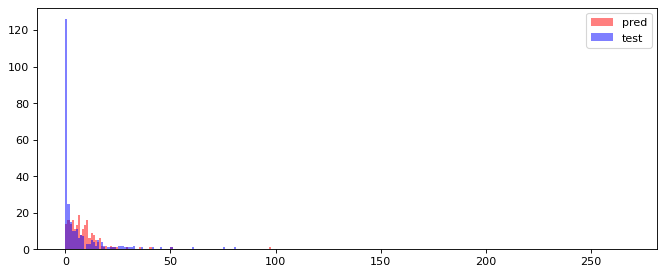

In [64]:
LinReg = LinearRegression_model(train_valid, test)

## Lasso Regression

In [69]:
def Lasso_model(train_valid, test):

    # define model
    model = LassoCV(cv=5, random_state=0) # 5-fold cross validation to select the best alpha

    # fit the model
    model.fit(get_features(train_valid), get_target(train_valid))

    # predict
    pred = model.predict(get_features(test))

    compute_results(pred, get_target(test))

    check_prediction_value(pred, get_target(test))

    return model

        mae         mse     rmse      osr2
0  5.918096  102.918992  10.1449  0.835893


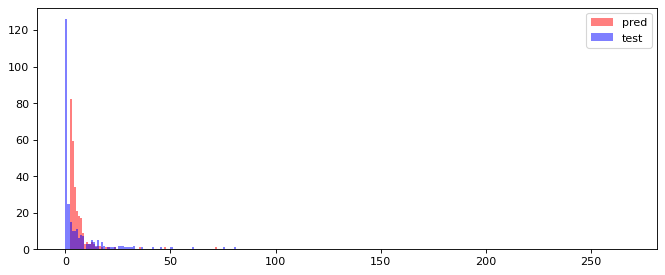

In [70]:
LassoReg = Lasso_model(train_valid, test)

## Random Forest

In [85]:
def RandomForest_model(train_valid, test):

    # define model
    model = RandomForestRegressor(n_estimators = 200, random_state=0)

    # define parameters
    parameters = {"max_depth": [10, 15, 20],
                  "min_samples_split": [2, 5, 10],
                  "max_features": [10, 15, 20],
                  }

    # define grid search
    grid = GridSearchCV(model, parameters)

    # fit the model
    grid.fit(get_features(train_valid), get_target(train_valid))

    # predict
    pred = grid.predict(get_features(test))

    compute_results(pred, get_target(test))

    check_prediction_value(pred, get_target(test))

    print(grid.best_params_)

    return grid.best_estimator_


        mae        mse      rmse      osr2
0  4.602806  65.271284  8.079065  0.530124
{'max_depth': 10, 'max_features': 20, 'min_samples_split': 2}


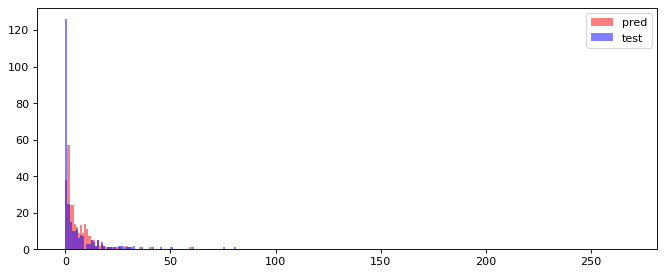

In [86]:
RFReg = RandomForest_model(train_valid, test)

## XGBoost

In [98]:
def XGB_model(train_valid, test):

    #  define model
    model = XGBRegressor(n_estimators = 200, random_state=0)

    # define parameters
    parameters = {"max_depth": [4, 6, 10],
                  "alpha": [0, 0.1, 0.3],
                  "eta": [0.001, 0.1, 0.3],
                  }

    # define grid search
    grid = GridSearchCV(model, parameters)

    # fit the model
    grid.fit(get_features(train_valid), get_target(train_valid))

    # predict
    pred = grid.predict(get_features(test))

    compute_results(pred, get_target(test))

    check_prediction_value(pred, get_target(test))

    print(grid.best_params_)

    return grid.best_estimator_
    


        mae        mse      rmse      osr2
0  4.720444  65.413068  8.087835  0.531276
{'alpha': 0, 'eta': 0.1, 'max_depth': 4}


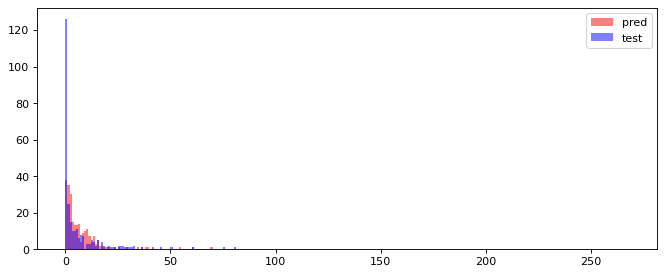

In [99]:
XGBReg = XGB_model(train_valid, test)